## Sentiment Anylisis Model Gift Cards
### COMP262 - Group 5
Juan Arevalo  
Jose Muniz  
Ruben Ormeno  
Samantha Ortiz de Foronda  
Mariela Ramos


## 1. Dataset data exploration

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#Load data
df = pd.read_json(r"C:\MR\Centennial\Sem4\NLP\Project\Gift_Cards_5.json\Gift_Cards_5.json",lines = True)

#### Field Description
overall (bigint) – User rating (1-5)  
verified (boolean)  Is the review verified (true, false)  
reviewtime (string) – Timestamp formatted like “10 30, 2009”  
reviewerid (string) – Amazon generated user id  
asin (string) – Unique Amazon generated product id  
reviewername (string) – User supplied name  
reviewtext (string) – Review text  
summary (string) – Summary of Review text  
unixreviewtime (bigint) – Timestamp formatted in epoch time  
vote (double) – Userful voters form other users  
style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"  
image -  images that users post after they have received the product  

### 1a. Counts, averages

In [3]:
# Base exploration
print('\n---Name and Types of colums---\n')
print(df.info())
print('\n---Shape----\n')
print(df.shape)



---Name and Types of colums---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2972 entries, 0 to 2971
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         2972 non-null   int64  
 1   verified        2972 non-null   bool   
 2   reviewTime      2972 non-null   object 
 3   reviewerID      2972 non-null   object 
 4   asin            2972 non-null   object 
 5   style           864 non-null    object 
 6   reviewerName    2972 non-null   object 
 7   reviewText      2966 non-null   object 
 8   summary         2972 non-null   object 
 9   unixReviewTime  2972 non-null   int64  
 10  vote            208 non-null    float64
 11  image           12 non-null     object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 258.4+ KB
None

---Shape----

(2972, 12)


In [4]:
# classes by variable
def check_columns(dataframe):
    total_counts = []
    unique_counts = []
    missing_values = []
    for column in dataframe.columns:
        try:
            # Attempt to count unique values in the usual way
            total_count = dataframe[column].count()
            unique_count = dataframe[column].nunique()
            missing_value = dataframe[column].isna().sum()
            
        except TypeError:
            # Handle unhashable items by converting them to strings (or another approach as needed)
            total_count = dataframe[column].astype(str).count()
            unique_count = dataframe[column].astype(str).nunique()
            missing_value = dataframe[column].astype(str).isna().sum() 
                
        total_counts.append(total_count)
        unique_counts.append(unique_count)
        missing_values.append(missing_value)

    # Create DataFrame with counts
    nunique_df = pd.DataFrame({'Column': dataframe.columns, 'Total counts': total_counts,'Unique Value': unique_counts, 'Missing values': missing_values})
    nunique_df = nunique_df.sort_values('Unique Value', ascending=False).reset_index(drop=True)
    return nunique_df
check_columns(df)

,Column,Total counts,Unique Value,Missing values
0,reviewText,2966,1937,6
1,summary,2972,952,0
2,reviewTime,2972,797,0
3,unixReviewTime,2972,797,0
4,reviewerID,2972,458,0
5,reviewerName,2972,429,0
6,asin,2972,148,0
7,vote,208,20,2764
8,style,2972,18,0
9,image,2972,13,0



Counts and Averages of Numerical Variables:
           overall  unixReviewTime        vote
count  2972.000000    2.972000e+03  208.000000
mean      4.885262    1.476136e+09    5.158654
std       0.484660    3.379616e+07    7.366121
min       1.000000    1.327968e+09    2.000000
25%       5.000000    1.454890e+09    2.000000
50%       5.000000    1.482710e+09    3.000000
75%       5.000000    1.500271e+09    5.000000
max       5.000000    1.534896e+09   60.000000


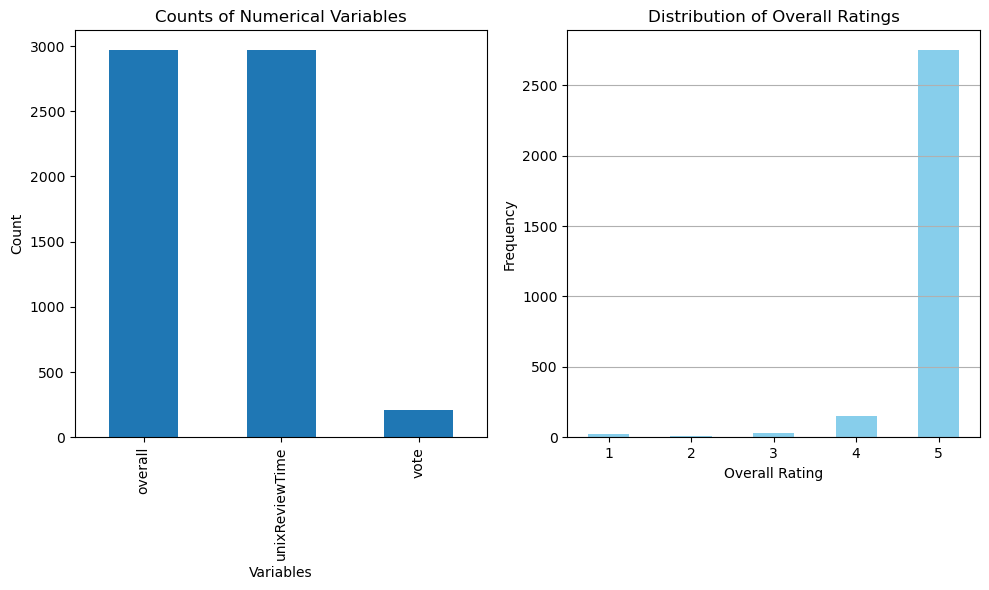

In [5]:

# Select numerical variables
numerical_variables = df.select_dtypes(include=['int64', 'float64'])

# Print summary statistics
print("\nCounts and Averages of Numerical Variables:")
print(numerical_variables.describe())

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for counts
plt.subplot(1, 2, 1)
numerical_variables.count().plot(kind='bar')
plt.title('Counts of Numerical Variables')
plt.xlabel('Variables')
plt.ylabel('Count')

# Line plot for averages
plt.subplot(1, 2, 2)
numerical_variables['overall'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  

plt.tight_layout()
plt.show()


### 1b. Distribution of number of reviews across products

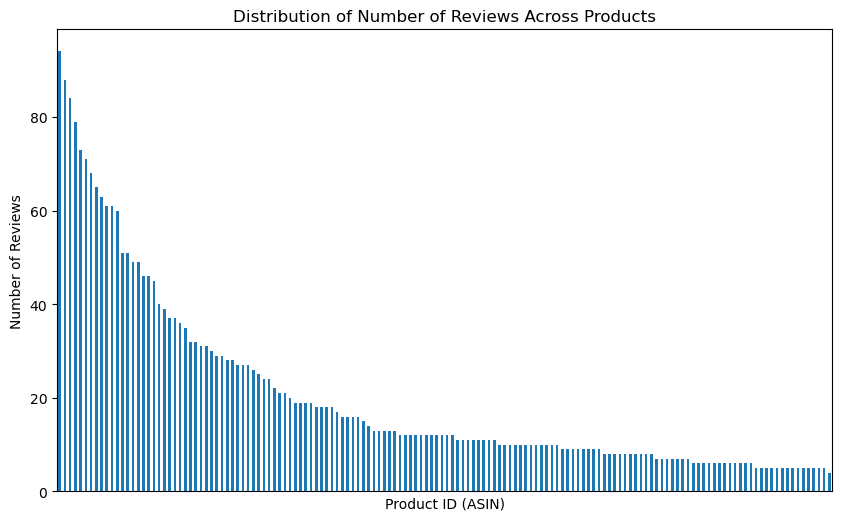

In [6]:
# Calculate the number of reviews per product (ASIN)
review_counts = df['asin'].value_counts()

# Create the plot
plt.figure(figsize=(10, 6))
review_counts.plot(kind='bar')
plt.title('Distribution of Number of Reviews Across Products')
plt.xlabel('Product ID (ASIN)')
plt.ylabel('Number of Reviews')
plt.xticks([])  # Rotate the x-axis labels for better readability
plt.show()

### 1c. Distribution of number of reviews per products

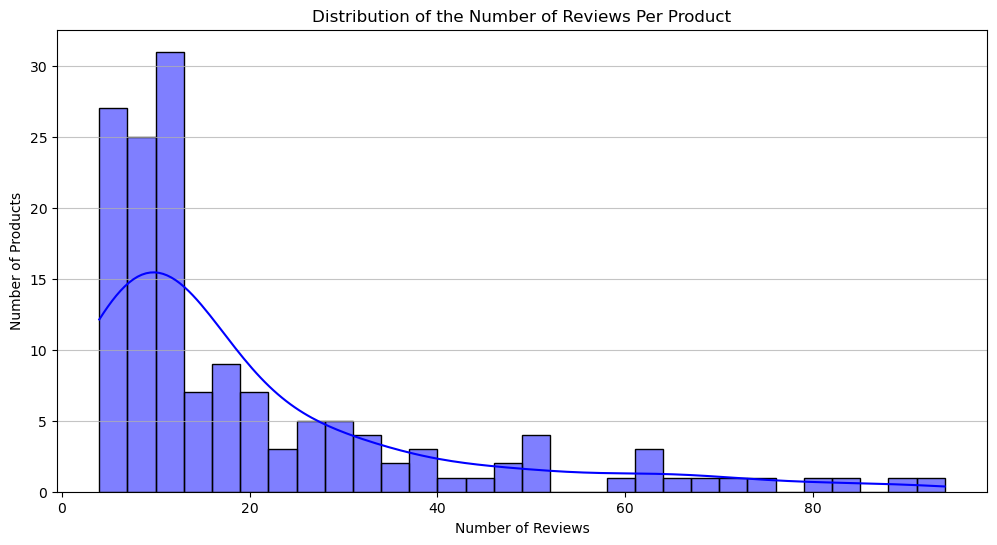

In [7]:

reviews_per_product = df['asin'].value_counts()

# plot using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_product, bins=30, kde=True, color='blue')
plt.title('Distribution of the Number of Reviews Per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Products')
plt.grid(axis='y', alpha=0.75)

plt.show()


- Most products have received between 10 and 20 reviews, as indicated by the tallest bar in the histogram.  
- Fewer products have a higher number of reviews, showing a decline in frequency as the number of reviews increases.

In [8]:
# Assuming 'df' is your DataFrame containing the dataset information

# Calculate the top 10 products with the most reviews and their counts
top_10_most_reviews = df['asin'].value_counts().head(10)

# Calculate the top 10 products with the least reviews and their counts
top_10_least_reviews = df['asin'].value_counts().tail(10)

print("Top 10 products with the most reviews:")
print(top_10_most_reviews)

print("\nTop 10 products with the least reviews:")
print(top_10_least_reviews)


Top 10 products with the most reviews:
asin
B00AR51Y5I    94
B004Q7CK9M    88
B0091JKVU0    84
B00BXLW5QC    79
B0091JKY0M    73
B01E4QUN0W    71
B00GOLGWVK    68
B00CHQ7I2S    65
B006PJHP62    63
B00PG8502O    61
Name: count, dtype: int64

Top 10 products with the least reviews:
asin
B00ET5WASC    5
B00BXLVD8I    5
B014S2HRVK    5
B015NKJ6D8    5
B00ELQD5K6    5
B016J1LGPG    5
B01CT5PHJ2    5
B00BXLSPGQ    5
B0188LOK7G    5
B01B25LU7S    4
Name: count, dtype: int64


### 1d. Distribution reviews per user

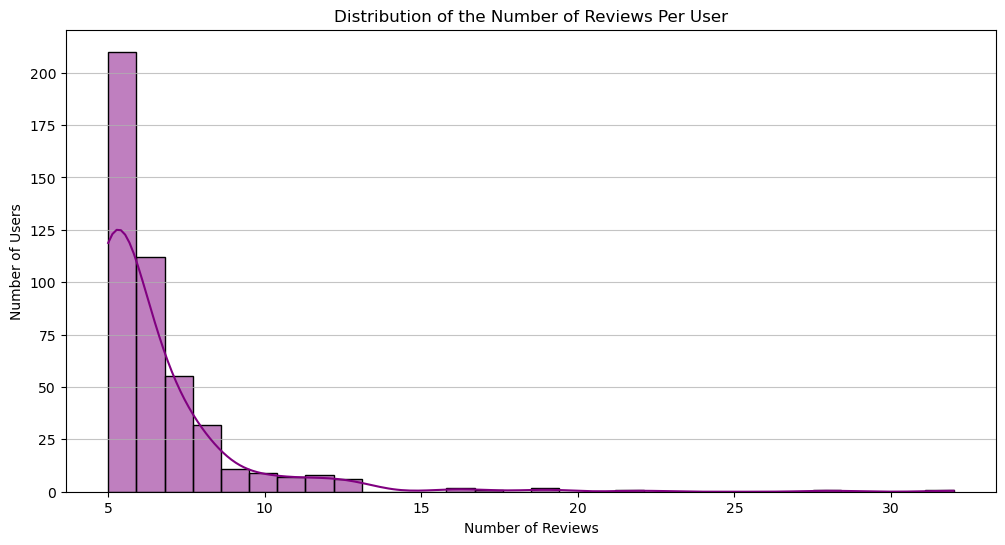

In [9]:
# Calculate the number of reviews per user
reviews_per_user = df['reviewerID'].value_counts()

# Plot the distribution of the number of reviews per user using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_user, bins=30, kde=True, color='purple')
plt.title('Distribution of the Number of Reviews Per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)

plt.show()

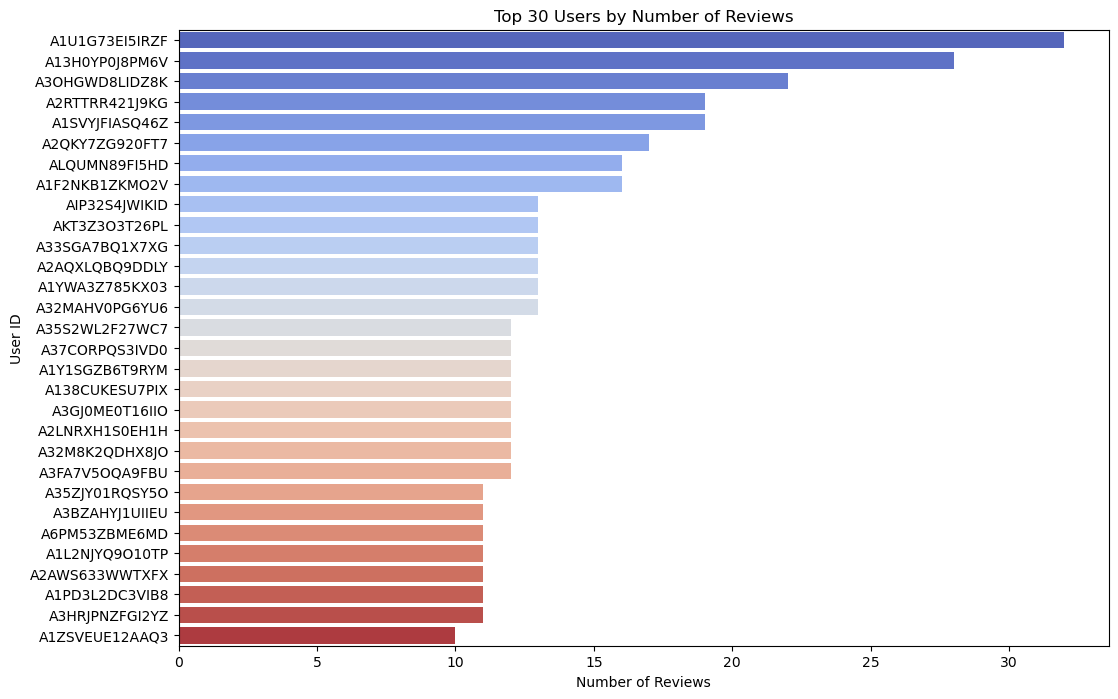

In [10]:
# Top 30 users with the most reviews and their counts
top_30_users_reviews = df['reviewerID'].value_counts().head(30)

# Plotting the distribution of reviews for the top 30 users
plt.figure(figsize=(12, 8))
sns.barplot(y=top_30_users_reviews.index, x=top_30_users_reviews.values, palette='coolwarm')
plt.title('Top 30 Users by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('User ID')

plt.show()

### 1e.	Review lengths and outliers

In [11]:
# Calculate review lengths
df_length = df['reviewText'].dropna().apply(lambda x: len(str(x).split()))

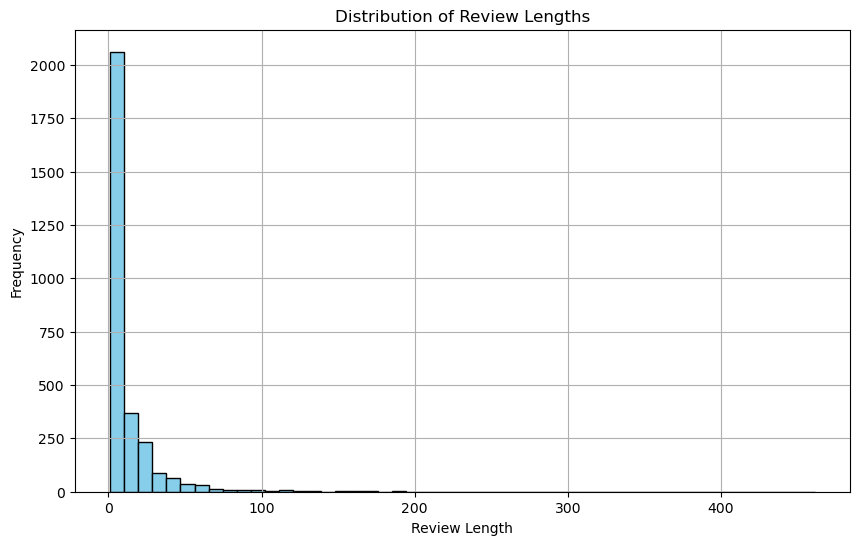

In [12]:
# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df_length, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Outlier threshold (Z-Score Method): 87.06347494420397


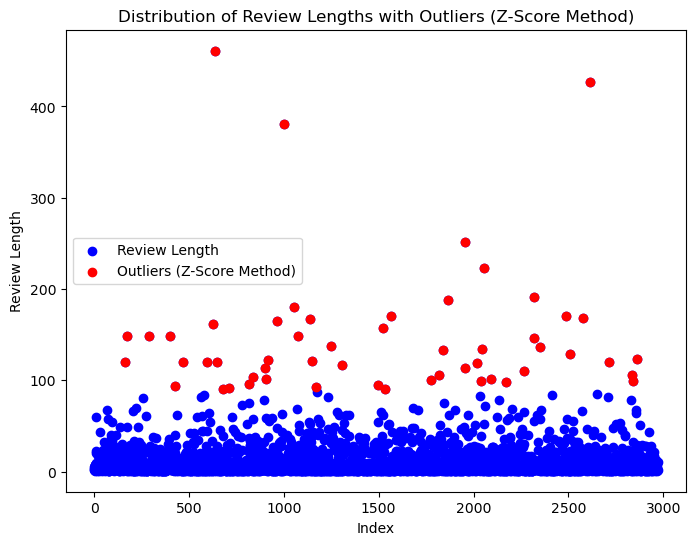

In [13]:
# Calculate z-scores

mean_length = df_length.mean()
std_length = df_length.std()
df_length_zscore = (df_length - mean_length) / std_length

# Define threshold for outliers using z-scores
z_score_threshold = 3

# Print outlier threshold
outlier_threshold = mean_length + z_score_threshold * std_length
print("Outlier threshold (Z-Score Method):", outlier_threshold)

# Identify outliers using z-scores
outliers_z_score = df_length[(df_length_zscore > z_score_threshold) | (df_length_zscore < -z_score_threshold)]

# Create a scatter plot to visualize the distribution of review lengths and identify outliers using z-scores
plt.figure(figsize=(8, 6))
plt.scatter(df_length.index, df_length, c='blue', label='Review Length')
plt.scatter(outliers_z_score.index, outliers_z_score, c='red', label='Outliers (Z-Score Method)')
plt.xlabel('Index')
plt.ylabel('Review Length')
plt.title('Distribution of Review Lengths with Outliers (Z-Score Method)')
plt.legend()
plt.show()


### 1f.	Analyze lengths

In [14]:
# review lengths
print("Minimum review length:", df_length.min())
print("Maximum review length:", df_length.max())
print("Average review length:", df_length.mean())

Minimum review length: 1
Maximum review length: 461
Average review length: 12.818273769386378


In [15]:
# Find the mode of review lengths
mode_length = stats.mode(df_length)

print("Mode of review lengths:", mode_length.mode.item())
print("Frequency of the mode:", mode_length.count.item())


Mode of review lengths: 1
Frequency of the mode: 413


### 1g. Check for duplicates

In [16]:
duplicates_df = df[df.duplicated(subset=['reviewerID', 'asin', 'unixReviewTime', 'reviewText'], keep=False)]

# Count the number of duplicate rows based on specific columns
duplicate_count = duplicates_df.shape[0]

print("Number of duplicate rows considering reviewerID, asin, unixReviewTime and reviewText:", duplicate_count)



Number of duplicate rows considering reviewerID, asin, unixReviewTime and reviewText: 0


## 2.	Text basic pre-processing:

### 2a. Labeling the data based on ratings

In [17]:
# Labeling the data based on ratings
def label_rating(row):
    if row['overall'] >= 4:
        return 'positive'
    elif row['overall'] == 3:
        return 'neutral'
    else:  # Ratings 1 and 2
        return 'negative'

df['rating_label'] = df.apply(label_rating, axis=1)

### 2b. Chose the appropriate columns for your sentiment analyzer

In [18]:
# Dropping columns 'image', 'vote', and 'style' columns because are not important for the analysis
df.drop(columns=['image', 'vote', 'style'], inplace=True, errors='ignore')
# Dropping'reviewerID','asin', 'reviewerName'
df.drop(columns=['reviewerID','asin', 'reviewerName' ], inplace=True, errors='ignore')
# Dropping 'summary' 
#df.drop(columns=['summary' ], inplace=True, errors='ignore')
# Dropping 'reviewTime'
df.drop(columns=['reviewTime', 'overall'], inplace=True)

# Chose the appropriate columns for your sentiment analyzer
df['reviewText'] = df['reviewText'].fillna('')
df['summary'] = df['summary'].fillna('')

# Combine 'reviewText' and 'summary' into a single column for a comprehensive sentiment analysis
df['combined_text'] = df['reviewText'] + " " + df['summary']

df.drop(columns=['reviewText', 'summary'], inplace=True, errors='ignore')


# Print the shape of the DataFrame to see the number of entries and columns
print("DataFrame shape:", df.shape)

df.head()

DataFrame shape: (2972, 4)


,verified,unixReviewTime,rating_label,combined_text
0,True,1529193600,positive,Another great gift. Five Stars
1,True,1528934400,positive,Gift card for my daughter Ease of use
2,True,1527897600,positive,Nice present Five Stars
3,True,1526688000,positive,My niece loved this birthday greeting/gift car...
4,True,1526601600,positive,fine as a gift. Five Stars


In [19]:
# Print a summary of any missing values in the combined_text column
print("\nMissing values in 'combined_text':", df['combined_text'].isnull().sum())



Missing values in 'combined_text': 0


### 2c.	Check for outliers

#### Unverified Reviewers outliers

In [20]:
def identify_unverified_reviewers(df):
    unverified_reviewers = df[df['verified'] == False]
    return len(unverified_reviewers)

# Usage
unverified_reviewers_count = identify_unverified_reviewers(df)
print("Number of Unverified Reviewers:", unverified_reviewers_count)


Number of Unverified Reviewers: 134


#### Word count outliers

In [21]:
# Check for outliers in 'combined_text' by word count
df['word_count'] = df['combined_text'].fillna('').apply(lambda x: len(x.split()))
print(df['word_count'].describe())

count    2972.000000
mean       15.793742
std        26.013748
min         2.000000
25%         4.000000
50%         7.000000
75%        17.000000
max       474.000000
Name: word_count, dtype: float64


Outlier threshold (Z-Score Method): 93.83498648163726


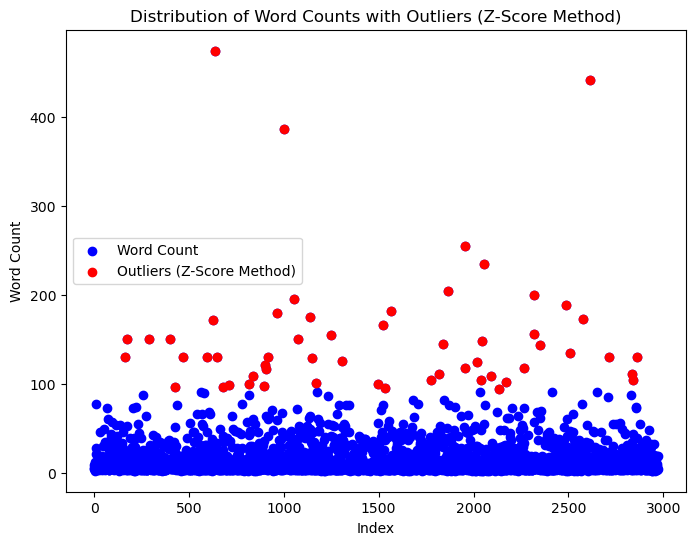

In [22]:
# Calculate z-scores
mean_length = df['word_count'].mean()
std_length = df['word_count'].std()

# Define threshold for outliers using z-scores
z_score_threshold = 3

# Print outlier threshold
outlier_threshold = mean_length + z_score_threshold * std_length
print("Outlier threshold (Z-Score Method):", outlier_threshold)

# Calculate z-scores for word count
wordcount_z_score = (df['word_count'] - mean_length) / std_length

# Identify outliers using z-scores
outliers_z_score = df['word_count'][(wordcount_z_score > z_score_threshold) | (wordcount_z_score < -z_score_threshold)]

# Create a scatter plot to visualize the distribution of review lengths and identify outliers using z-scores
plt.figure(figsize=(8, 6))
plt.scatter(df['word_count'].index, df['word_count'], c='blue', label='Word Count')
plt.scatter(outliers_z_score.index, outliers_z_score, c='red', label='Outliers (Z-Score Method)')
plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Distribution of Word Counts with Outliers (Z-Score Method)')
plt.legend()
plt.show()

In [23]:
# Filter rows where word count is less than or equal to 94
df = df[df['word_count'] <= 94]

# Drop the 'word_count' column as it's no longer needed
df.drop(columns=['word_count'], inplace=True)

# Optionally, you can reset the index of the DataFrame after dropping rows
df.reset_index(drop=True, inplace=True)

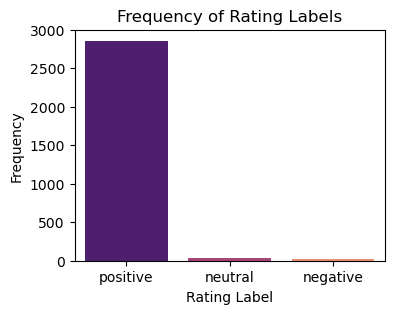

Shape of dataframe: (2917, 4)


In [24]:
# Count the frequency of each rating label
label_counts = df['rating_label'].value_counts()

# Plot the frequency of each rating label using seaborn
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='magma')
plt.title('Frequency of Rating Labels')
plt.xlabel('Rating Label')
plt.ylabel('Frequency')

plt.show()
print("Shape of dataframe:", df.shape)

In [26]:
df.head()

,verified,unixReviewTime,rating_label,combined_text
0,True,1529193600,positive,Another great gift. Five Stars
1,True,1528934400,positive,Gift card for my daughter Ease of use
2,True,1527897600,positive,Nice present Five Stars
3,True,1526688000,positive,My niece loved this birthday greeting/gift car...
4,True,1526601600,positive,fine as a gift. Five Stars


#### Reviewers outliers

In [53]:
# Remove leading and trailing whitespaces and convert to lowercase
df['reviewText_cleaned'] = df['reviewText'].str.strip().str.lower()

# Group by reviewerID and reviewText_cleaned (cleaned review text) and count the occurrences
review_frequency = df.groupby(['reviewerID', 'reviewText_cleaned','reviewTime']).size().reset_index(name='review_count')

# Sort the list by review count in descending order
review_frequency_sorted = review_frequency.sort_values(by='review_count', ascending=False)

# Print the sorted DataFrame
print(review_frequency_sorted.head())

# Calculate the mean review count
mean_review_count = review_frequency['review_count'].mean()
print("\nMean review count:", mean_review_count)

# Calculate the standard deviation of review counts
std_review_count = review_frequency['review_count'].std()

# Define a threshold for outliers (3 standard deviations from the mean)
threshold = 3

# Calculate the lower and upper bounds for outliers
lower_bound = mean_review_count - (threshold * std_review_count)
upper_bound = mean_review_count + (threshold * std_review_count)

# Identify outliers based on the bounds
outliers = review_frequency[(review_frequency['review_count'] < lower_bound) | (review_frequency['review_count'] > upper_bound)]

# Print the outliers
print("\nOutliers:")
print(outliers)

          reviewerID                 reviewText_cleaned   reviewTime  \
1523  A3OHGWD8LIDZ8K      fast delivery and card worked  03 10, 2015   
1920   ALQUMN89FI5HD  great gift card worked perfectly.  11 27, 2017   
1908   AKT3Z3O3T26PL                              great  02 15, 2018   
1159  A32MAHV0PG6YU6    does what a gift card should :)  12 14, 2017   
566   A1YWA3Z785KX03               arrived within 5 min  03 10, 2017   

      review_count  
1523            21  
1920            16  
1908            13  
1159            13  
566             11  

Mean review count: 1.3900841908325539

Outliers:
          reviewerID                                 reviewText_cleaned  \
8     A11F143J72N3QZ                                               gift   
85    A15FGESGPI84VP                                   its a gift card.   
90    A16QCOFOP5DW4I                                              great   
167   A1EKEP11L6DPIM                                        thank you!!   
189   A1FJGAOIKU

## 4. Pre-process the text for VADER

In [512]:
# Step 1: Perform Sentiment Analysis
# Ensure you have the VADER lexicon downloaded
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score for a text
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis on the combined review texts
df['sentiment_score'] = df['combined_text'].apply(get_sentiment_score)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ryaol/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [513]:
df['rating_label'].value_counts()

rating_label
positive    2906
negative      33
neutral       33
Name: count, dtype: int64

In [514]:
df['overall'].value_counts()

overall
5    2752
4     154
3      33
1      22
2      11
Name: count, dtype: int64

In [515]:
df['sentiment_score'].describe()

count    2972.000000
mean        0.619738
std         0.329863
min        -0.974600
25%         0.440400
50%         0.700300
75%         0.872000
max         0.999400
Name: sentiment_score, dtype: float64

In [516]:
df['rating_label_vader'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 
                                                       else ('neutral' 
                                                             #if (x > -0.05 and x < 0.05) 
                                                             if(x == 0)
                                                             else 'negative'))


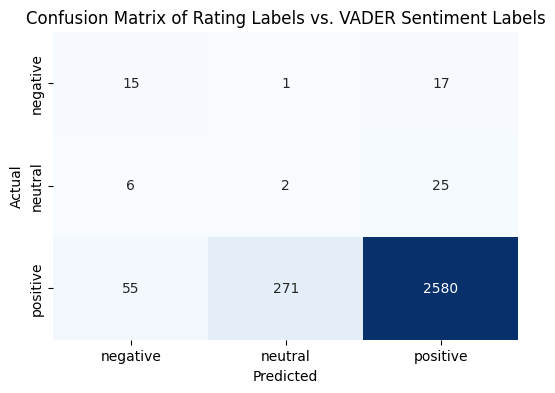

In [517]:
#Comparing the rating labels and the VADER sentiment labels
# Create a confusion matrix
conf_matrix = pd.crosstab(df['rating_label'], df['rating_label_vader'], rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix of Rating Labels vs. VADER Sentiment Labels')
plt.show()

In [518]:
#printing the accuracy of the VADER sentiment labels
# Calculate the accuracy of the VADER sentiment labels
accuracy = (conf_matrix['negative']['negative'] + conf_matrix['positive']['positive'] + conf_matrix['neutral']['neutral']) / conf_matrix.values.sum()
print("accuracy of vader lexicon:", accuracy)
from sklearn.metrics import f1_score
F1_score = f1_score(df['rating_label'], df['rating_label_vader'], average='weighted')
print("F1 score of vader lexicon:", F1_score)

accuracy of vader lexicon: 0.8738223418573351
F1 score of vader lexicon: 0.9159016048180161


In [519]:
#show the reviews that are misclassified
misclassified_reviews = df[df['rating_label'] != df['rating_label_vader']]

In [520]:
misclassified_reviews.count()

overall               375
verified              375
reviewTime            375
reviewerID            375
asin                  375
reviewerName          375
reviewText            375
summary               375
unixReviewTime        375
ID_Name               375
rating_label          375
combined_text         375
word_count            375
z_score               375
reviewText_cleaned    375
sentiment_score       375
rating_label_vader    375
dtype: int64

In [521]:
pd.set_option('display.max_colwidth', None)
misclassified_reviews[(misclassified_reviews['rating_label'] == 'positive') & (misclassified_reviews['rating_label_vader'] == 'negative')][['rating_label','rating_label_vader','combined_text']]


,rating_label,rating_label_vader,combined_text
39,positive,negative,"How can you go wrong with a amazon gift certificate, you can't Terrific"
95,positive,negative,If you are ever stuck on what to get kids (tweens) this is the way to go!\nWho does not love gift cards? They are the same as cash and not as impersonal. That way they spend the money to get what they want and you know they cannot return to store to exchange. Great gift idea
100,positive,negative,"Once again, who but Donald Trump (perhaps The Walton family) could hate an Amazon Gift Card? who but Donald Trump (perhaps The Walton family) could hate an Amazon Gift Card"
173,positive,negative,"Delivered as expected, no complaints! Five Stars"
295,positive,negative,What's not to like Five Stars
312,positive,negative,Easy to use No problems
354,positive,negative,Whats not to love about a gift card ??? Five Stars
512,positive,negative,What's not to love Five Stars
649,positive,negative,Who won't love a gift? Plus it was nicely packed with a good quality cardboard box. They are hard card boards and has magnetics to keep them shut. Who won't love a gift?
681,positive,negative,"Kinda funky. Thought it would be prettier than it is. Just tin, but it's what's inside that counts. Right? Never saw a snowflake like this."


In [522]:
misclassified_reviews[(misclassified_reviews['rating_label']=='positive') & (misclassified_reviews['rating_label_vader']=='negative')][['rating_label','rating_label_vader',]]

,rating_label,rating_label_vader
39,positive,negative
95,positive,negative
100,positive,negative
173,positive,negative
295,positive,negative
312,positive,negative
354,positive,negative
512,positive,negative
649,positive,negative
681,positive,negative


## 5. Selecting 1000 reviews from the dataset

In [523]:
#selecting 1000 reviews randomly
df_1000 = df.sample(n=1000, random_state=1)
df_1000.head()


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,ID_Name,rating_label,combined_text,word_count,z_score,reviewText_cleaned,sentiment_score,rating_label_vader
1984,5,True,"01 4, 2016",A15FGESGPI84VP,B00JJ59UA8,Tamara from NC,Its a gift card.,Five Stars,1451865600,A15FGESGPI84VP - Tamara from NC,positive,Its a gift card. Five Stars,6,-0.376483,its a gift card.,0.4404,positive
2369,5,True,"12 21, 2015",A3G5OIVLDJLM7B,B00UW1CEMY,Amazon Customer,Good ideal,convenient,1450656000,A3G5OIVLDJLM7B - Amazon Customer,positive,Good ideal convenient,3,-0.491807,good ideal,0.7430,positive
2085,5,True,"11 9, 2015",ASMBYX11IUPJR,B00MV9H6VY,Brian Miller,good gift card,good,1447027200,ASMBYX11IUPJR - Brian Miller,positive,good gift card good,4,-0.453366,good gift card,0.8271,positive
1783,5,True,"12 6, 2016",A1L2NJYQ9O10TP,B00GOLGWVK,Lee,Great price and good food.,Five Stars,1480982400,A1L2NJYQ9O10TP - Lee,positive,Great price and good food. Five Stars,7,-0.338042,great price and good food.,0.7906,positive
1965,5,True,"01 18, 2016",A2W3RQOSC87P4A,B00JDQJZWG,Linda Murphy on,"My gift cerficate, including this adorable cupcake, was delivered in record time. Thank you!....","including this adorable cupcake, was delivered in record time",1453075200,A2W3RQOSC87P4A - Linda Murphy on,positive,"My gift cerficate, including this adorable cupcake, was delivered in record time. Thank you!.... including this adorable cupcake, was delivered in record time",23,0.277017,"my gift cerficate, including this adorable cupcake, was delivered in record time. thank you!....",0.9215,positive


## 6.A Modeling (Sentiment Analysis) - VADER Lexicon Approach

In [524]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import string


# Load spaCy model for tokenization
nlp = spacy.load('en_core_web_sm')

# Define the list of stopwords and create the lemmatizer object
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text using spaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize each word
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


df_1000['reviews_after_preprocessing'] = df_1000['combined_text'].apply(preprocess_text)
df_1000['reviews_after_preprocessing'].head()


1984                                                                                                                     gift card . Five Stars
2369                                                                                                                      Good ideal convenient
2085                                                                                                                        good gift card good
1783                                                                                                         Great price good food . Five Stars
1965    gift cerficate , including adorable cupcake , delivered record time .   Thank ! .... including adorable cupcake , delivered record time
Name: reviews_after_preprocessing, dtype: object

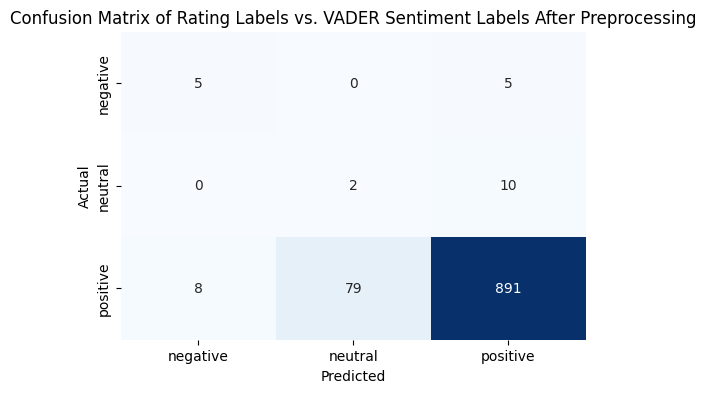

In [525]:
df_1000['vader_sentiment_score_after_preprocessing'] = df_1000['reviews_after_preprocessing'].apply(get_sentiment_score)
df_1000['rating_label_vader_after_preprocessing'] = df_1000['vader_sentiment_score_after_preprocessing'].apply(lambda x: 'positive' if x > 0
                                                                                                     else ('neutral' if x == 0
                                                                                                           else 'negative'))
confmatrix_after_preprocessing = pd.crosstab(df_1000['rating_label'], df_1000['rating_label_vader_after_preprocessing'], rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(6,4))
sns.heatmap(confmatrix_after_preprocessing, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix of Rating Labels vs. VADER Sentiment Labels After Preprocessing')
plt.show()

In [526]:
#printing the accuracy of the VADER sentiment labels after preprocessing
accuracy_after_preprocessing = (confmatrix_after_preprocessing['negative']['negative'] + confmatrix_after_preprocessing['positive']['positive'] + confmatrix_after_preprocessing['neutral']['neutral']) / confmatrix_after_preprocessing.values.sum()
print("accuracy of vader lexicon after preprocessing:", accuracy_after_preprocessing)
F1_score_after_preprocessing = f1_score(df_1000['rating_label'], df_1000['rating_label_vader_after_preprocessing'], average='weighted')
print("F1 score of vader lexicon after preprocessing:", F1_score_after_preprocessing)

accuracy of vader lexicon after preprocessing: 0.898
F1 score of vader lexicon after preprocessing: 0.9299149105332273


## 6.A Modeling (Sentiment Analysis) - sentiwordnet Lexicon Approach

In [216]:
#Defining a function to get the sentiwordnet score for a sentence
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

def get_sentiwordnet_score(text):
    # Tokenize the text using spaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize each word
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Get the sentiment score for each word
    pos_score = 0
    neg_score = 0
    for token in tokens:
        synsets = wn.synsets(token)
        if synsets:
            synset = synsets[0]
            senti_synset = swn.senti_synset(synset.name())
            pos_score += senti_synset.pos_score()
            neg_score += senti_synset.neg_score()

    return pos_score - neg_score

In [217]:
df['combined_text'][0]
aux_tokens = nlp(df['combined_text'][0])
aux_tokens = [token.text for token in aux_tokens]
aux_tokens = [token for token in aux_tokens if token.lower() not in stop_words]
aux_tokens = [lemmatizer.lemmatize(token) for token in aux_tokens]
df['combined_text'][0], aux_tokens

('Another great gift. Five Stars',
 ['Another', 'great', 'gift', '.', 'Five', 'Stars'])

In [223]:
pos_score = 0
neg_score = 0
for token in aux_tokens:
    synsets = wn.synsets(token)
    print("Token: ",token)
    print("Synsets:",synsets)
    '''
    print("SentiWordNet Pos-Score:",swn.senti_synset.pos_score())
    print("SentiWordNet Neg-Score:",swn.senti_synset.neg_score())
    print("SentiWordNet Obj-Score:",swn.senti_synset.obj_score())



    if synsets:
        synset = synsets[0]
        senti_synset = swn.senti_synset(synset.name())
        pos_score += senti_synset.pos_score()
        neg_score += senti_synset.neg_score()

print("Positive score:", pos_score)
print("Negative score:", neg_score)
print("Sentiwordnet score:", pos_score - neg_score) 
'''

Token:  Another
Synsets: [Synset('another.s.01')]
Token:  great
Synsets: [Synset('great.n.01'), Synset('great.s.01'), Synset('great.s.02'), Synset('great.s.03'), Synset('bang-up.s.01'), Synset('capital.s.03'), Synset('big.s.13')]
Token:  gift
Synsets: [Synset('gift.n.01'), Synset('endowment.n.01'), Synset('giving.n.01'), Synset('endow.v.01'), Synset('give.v.08')]
Token:  .
Synsets: []
Token:  Five
Synsets: [Synset('five.n.01'), Synset('basketball_team.n.01'), Synset('five-spot.n.03'), Synset('five.s.01')]
Token:  Stars
Synsets: [Synset('star.n.01'), Synset('ace.n.03'), Synset('star.n.03'), Synset('star.n.04'), Synset('star.n.05'), Synset('headliner.n.01'), Synset('asterisk.n.01'), Synset('star_topology.n.01'), Synset('star.v.01'), Synset('star.v.02'), Synset('star.v.03')]


In [226]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

def get_word_pos(sentence):
    # Tokenize the sentence
    tokens = word_tokenize(sentence)
    # Perform POS tagging
    pos_tags = nltk.pos_tag(tokens)  # Rename variable to avoid conflict
    # Create a dictionary to store the POS tags of each word
    pos_dict = {}
    for word, pos_tag in pos_tags:
        pos_dict[word] = pos_tag
    return pos_dict

# Example usage
sentence = "She quickly ran to the store."
pos_dict = get_word_pos(sentence)
print(pos_dict)


{'She': 'PRP', 'quickly': 'RB', 'ran': 'VBD', 'to': 'TO', 'the': 'DT', 'store': 'NN', '.': '.'}


In [231]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Function to map NLTK POS tags to SentiWordNet POS tags
def map_pos_tag(nltk_pos_tag):
    if nltk_pos_tag.startswith('N'):  # Noun
        return 'n'
    elif nltk_pos_tag.startswith('V'):  # Verb
        return 'v'
    elif nltk_pos_tag.startswith('J'):  # Adjective
        return 'a'
    elif nltk_pos_tag.startswith('R'):  # Adverb
        return 'r'
    else:
        return None  # Handle unknown POS tags

# Function to get SentiWordNet score for a word
def get_sentiwordnet_score(word, nltk_pos_tag):
    sentiwordnet_pos_tag = map_pos_tag(nltk_pos_tag)
    if sentiwordnet_pos_tag:
        # Get synsets for the word using SentiWordNet's POS tag
        synsets = list(swn.senti_synsets(word, sentiwordnet_pos_tag))
        if synsets:
            # Calculate average positive and negative scores
            pos_scores = [synset.pos_score() for synset in synsets]
            neg_scores = [synset.neg_score() for synset in synsets]
            avg_pos_score = sum(pos_scores) / len(pos_scores)
            avg_neg_score = sum(neg_scores) / len(neg_scores)
            return avg_pos_score, avg_neg_score
    return None, None  # Return None if word not found or POS tag not recognized

def delete_words_for_sentiwordnet(text):
    # Tokenize the text using spaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize each word
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

# Example usage
sentence = "She quickly ran to the store."
sentence = delete_words_for_sentiwordnet(sentence)
tokens = word_tokenize(sentence)
pos_tags = nltk.pos_tag(tokens)
print("pos_tags:", pos_tags)
word_scores = {}
for token, pos_tag in pos_tags:
    print("pairs:",token, pos_tag)
    pos_tag_swn = map_pos_tag(pos_tag)
    print("tag for sentiwornet",pos_tag_swn)
    if pos_tag_swn:
        pos_score, neg_score = get_sentiwordnet_score(token, pos_tag_swn)
        if pos_score is not None and neg_score is not None:
            word_scores[token] = {'Positive': pos_score, 'Negative': neg_score}

print(word_scores)


pos_tags: [('She', 'PRP'), ('quickly', 'RB'), ('ran', 'VBD'), ('to', 'TO'), ('the', 'DT'), ('store', 'NN'), ('.', '.')]
pairs: She PRP
tag for sentiwornet None
pairs: quickly RB
tag for sentiwornet r
pairs: ran VBD
tag for sentiwornet v
pairs: to TO
tag for sentiwornet None
pairs: the DT
tag for sentiwornet None
pairs: store NN
tag for sentiwornet n
pairs: . .
tag for sentiwornet None
{}


In [233]:
nltk.download('sentiwordnet')
list(swn.senti_synsets('quickly'))

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/ryaol/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


[]

In [247]:
# Get the list of senti_synsets for the word 'quickly.r.01'
senti_synsets = list(swn.senti_synsets('good'))
print(senti_synsets)
# Now you can access the pos_score of each senti_synset in the list
pos_scores = [synset.pos_score() for synset in senti_synsets]

# Print the list of pos_scores
print(pos_scores)


[SentiSynset('good.n.01'), SentiSynset('good.n.02'), SentiSynset('good.n.03'), SentiSynset('commodity.n.01'), SentiSynset('good.a.01'), SentiSynset('full.s.06'), SentiSynset('good.a.03'), SentiSynset('estimable.s.02'), SentiSynset('beneficial.s.01'), SentiSynset('good.s.06'), SentiSynset('good.s.07'), SentiSynset('adept.s.01'), SentiSynset('good.s.09'), SentiSynset('dear.s.02'), SentiSynset('dependable.s.04'), SentiSynset('good.s.12'), SentiSynset('good.s.13'), SentiSynset('effective.s.04'), SentiSynset('good.s.15'), SentiSynset('good.s.16'), SentiSynset('good.s.17'), SentiSynset('good.s.18'), SentiSynset('good.s.19'), SentiSynset('good.s.20'), SentiSynset('good.s.21'), SentiSynset('well.r.01'), SentiSynset('thoroughly.r.02')]
[0.5, 0.875, 0.625, 0.0, 0.75, 0.0, 1.0, 1.0, 0.625, 1.0, 0.75, 0.625, 0.625, 0.5, 0.5, 0.375, 0.625, 0.0, 0.625, 0.75, 0.75, 0.875, 0.5, 0.375, 0.75, 0.375, 0.0]


In [248]:
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize

sentence = "The good book I read was very informative."
word = "good"
synset = lesk(word_tokenize(sentence), word)
print(synset)


Synset('well.r.01')


In [ ]:
#Getting the sentiwordnet score
df['sentiwordnet_sentiment_score'] = df['reviews_after_preprocessing'].apply(lambda x: get_sentiment_score(x))